In [1]:
#pip install pandas

In [2]:
#pip install statsmodels

In [3]:
    #pip install matplotlib

In [4]:
#pip install scikit-learn

In [5]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
from math import sqrt

In [40]:
# Load and preprocess the data
def load_and_clean_data(file_path):
    # Load the data
    df = pd.read_csv(file_path)
    # Ensure the date column is in datetime format
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    # Sort the dataframe by date
    df = df.sort_values('purchase_date')
    # Calculate total sales
    df['total_sales'] = df['purchase_qty'] * df['sales_price']
    # Exclude outliers (purchase_qty > 100)
    df = df[df['purchase_qty'] <= 100]
    # Drop all null values
    df = df.dropna()  
    return df

In [7]:
# Aggregate data by date
def aggregate_daily_sales(df):
    return df.groupby('purchase_date').agg({
        'total_sales': 'sum',
        'purchase_qty': 'sum',
        'sales_price': 'mean'
    }).reset_index().set_index('purchase_date')

In [8]:
# # Function to fit ARIMA model and forecast
# def fit_arima_and_forecast(series, steps, start_date, order=(1,1,1)):
#     model = ARIMA(series, order=order)
#     results = model.fit()
#     forecast = results.forecast(steps=steps)
#     forecast_index = pd.date_range(start=start_date, periods=steps, freq='D')
#     return pd.Series(forecast, index=forecast_index)

In [9]:
# Calculate RMSE
def calculate_rmse(actual, predicted):
    mask = ~np.isnan(actual) & ~np.isnan(predicted)
    if not mask.any():
        print("Warning: No valid data points to calculate RMSE")
        return None
    return sqrt(mean_squared_error(actual[mask], predicted[mask]))


In [41]:
# Load and clean data
df = load_and_clean_data('sales_data.csv')
print(f"Cleaned data shape: {df.shape}")

# Aggregate daily sales
daily_sales = aggregate_daily_sales(df)
print(f"Daily sales data shape: {daily_sales.shape}")

# Split into training and test sets
split_date = '2024-09-01'
train = daily_sales[daily_sales.index < split_date]
test = daily_sales[daily_sales.index >= split_date]

print(f"Training data range: {train.index.min()} to {train.index.max()}")
print(f"Test data range: {test.index.min()} to {test.index.max()}")


Cleaned data shape: (265116, 11)
Daily sales data shape: (72817, 3)
Training data range: 2018-01-01 00:00:00 to 2024-08-31 23:50:50
Test data range: 2024-09-01 00:50:51 to 2024-10-20 23:54:34


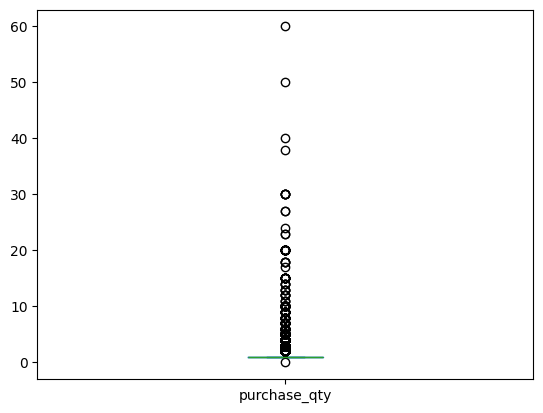

In [42]:
# df['purchase_qty'].plot(kind='box')
# plt.show()

In [11]:
train.head()

,total_sales,purchase_qty,sales_price
purchase_date,,,
2018-01-01,109770.0,27,4065.555556
2018-01-02,116350.0,30,3878.333333
2018-01-03,134687.0,37,3640.189189
2018-01-04,105340.0,29,3632.413793
2018-01-05,152340.0,40,3808.500000


In [43]:
# Fit ARIMA model on training data
model = ARIMA(train['total_sales'], order=(1,1,1))
results = model.fit()

c:\Users\lkenneth\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\lkenneth\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\lkenneth\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [44]:
# Generate forecasts for train and test periods
train_forecast = results.predict(start=train.index.min(), end=train.index.max())
test_forecast = results.forecast(steps=len(test))

c:\Users\lkenneth\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\lkenneth\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [45]:
# # Forecast total sales for both train and test periods
# train_forecast = fit_arima_and_forecast(train['total_sales'], steps=len(train), start_date=train.index.min())
# test_forecast = fit_arima_and_forecast(train['total_sales'], steps=len(test), start_date=test.index.min())

In [46]:
# Prepare train dataset
train_df = train.reset_index()
train_df.columns = ['date', 'total_sales', 'purchase_qty', 'sales_price']

In [47]:
# Align train_forecast with train_df
train_forecast = train_forecast.reindex(train_df['date'])
train_df['sales_forecast'] = train_forecast.values

In [48]:
test_forecast.head()

69881    3518.802741
69882    5103.229643
69883    6009.906225
69884    6528.745196
69885    6825.646962
Name: predicted_mean, dtype: float64

In [49]:
# Prepare test dataset
test_df = test.reset_index()
test_df.columns = ['date', 'total_sales', 'purchase_qty', 'sales_price']


In [50]:
# Create a date range for test_forecast
test_date_range = pd.date_range(start=test.index[0], periods=len(test_forecast), freq='D')
    
# Create a Series with the correct date index for test_forecast
test_forecast_series = pd.Series(test_forecast, index=test_date_range)
    
# Merge test_df with test_forecast_series
test_df = test_df.merge(test_forecast_series.rename('sales_forecast'), left_on='date', right_index=True, how='left')

In [51]:
test_df.head(10)

,date,total_sales,purchase_qty,sales_price,sales_forecast
0,2024-09-01 00:50:51,300.0,1,300.0,NaN
1,2024-09-01 01:10:51,1200.0,1,1200.0,NaN
2,2024-09-01 02:50:53,6460.0,2,3230.0,NaN
3,2024-09-01 09:51:00,5744.0,1,5744.0,NaN
4,2024-09-01 10:11:00,750.0,1,750.0,NaN
5,2024-09-01 10:21:00,2985.0,1,2985.0,NaN
6,2024-09-01 10:41:01,8274.0,3,2758.0,NaN
7,2024-09-01 11:11:02,590.0,1,590.0,NaN
8,2024-09-01 11:21:02,1500.0,3,500.0,NaN
9,2024-09-01 11:41:02,3584.0,1,3584.0,NaN


In [57]:
train_df.head()

,date,total_sales,purchase_qty,sales_price,sales_forecast
0,2018-01-01,109770.0,27,4065.555556,0.000000
1,2018-01-02,116350.0,30,3878.333333,86563.897296
2,2018-01-03,134687.0,37,3640.189189,95659.917027
3,2018-01-04,105340.0,29,3632.413793,112134.939005
4,2018-01-05,152340.0,40,3808.500000,94427.794589


In [53]:
# Save train and test datasets to CSV
train_df.to_csv('sales_forecast_train.csv', index=False)
test_df.to_csv('sales_forecast_test.csv', index=False)

print("Train dataset saved to 'sales_forecast_train.csv'")
print("Test dataset saved to 'sales_forecast_test.csv'")

Train dataset saved to 'sales_forecast_train.csv'
Test dataset saved to 'sales_forecast_test.csv'


In [54]:
# Calculate RMSE for test set
rmse = calculate_rmse(test_df['total_sales'], test_df['sales_forecast'])
print(f"\nTotal Sales RMSE (Test Set): {rmse}")


Total Sales RMSE (Test Set): None


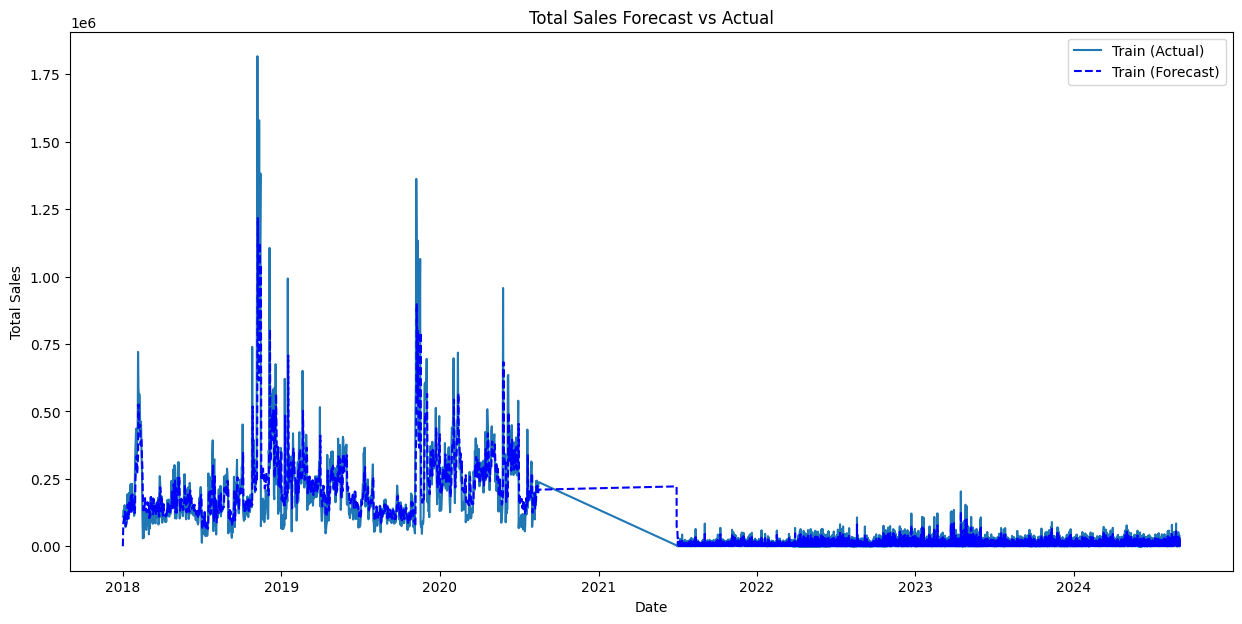

In [55]:
# Plot results
plt.figure(figsize=(15, 7))
plt.plot(train_df['date'], train_df['total_sales'], label='Train (Actual)')
plt.plot(train_df['date'], train_df['sales_forecast'], color='blue', linestyle='--', label='Train (Forecast)')
# plt.plot(test_df['date'], test_df['total_sales'], label='Test (Actual)')
# plt.plot(test_df['date'], test_df['sales_forecast'], color='red', linestyle='--', label='Test (Forecast)')
plt.title('Total Sales Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

In [56]:
    # # Generate a summary of sales by product category
    # category_summary = df.groupby('category').agg({
    #     'total_sales': 'sum',
    #     'purchase_qty': 'sum',
    #     'sales_price': 'mean'
    # }).sort_values('total_sales', ascending=False)

    # print("\nSales Summary by Product Category:")
    # print(category_summary)

    # # Save category summary to CSV
    # category_summary.to_csv('category_summary.csv')